In [1]:
import os
import pandas as pd

directory_path = './data/raw-txt'

alignment_df = pd.read_csv('./data/combined_csv.csv')
def ensure_txt_extension(filename):
    if pd.isnull(filename):
        return None  # Handles NaN values gracefully
    if not filename.endswith('.txt'):
        return f"{filename}.txt"
    return filename
alignment_df['filename'] = alignment_df['filename'].apply(ensure_txt_extension)

# Function to read text from a .txt file
def read_txt(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        return file.read()

documents_list = []
ranks = []
uni_names = []

for index, row in alignment_df.iterrows():
    # Check if the filename is not NaN (not a float)
    if not pd.isna(row['filename']) and isinstance(row['filename'], str):
        file_path = os.path.join(directory_path, row['filename'])
        if os.path.exists(file_path):
            text = read_txt(file_path)
            documents_list.append(text)
            ranks.append(row['qs_ranking'])
            uni_names.append(row['institution'])
        else:
            print(f"File does not exist: {file_path}")
    else:
        # Handle the case where filename is NaN or not a string
        print(f"Invalid or missing filename at index {index}")

# Convert lists to DataFrame
documents_df = pd.DataFrame({
    'document': documents_list,
    'rank': ranks,
    'institution': uni_names
})



In [2]:
documents_df

,document,rank,institution
0,"FINAL : APPROVED DECEMBER 8 , 2022 \n \n20...",102,University of Wisconsin-Madison
1,PLAN\n2020 • 2025DEVELOPMENT\nPLAN\n2020 • 202...,103,The Pontifical Catholic University of Chile
2,GO FURTHER2021–2025\nTransforming lives \nthr...,104,The University of Sheffield
3,\n UFV 2018/641 \nUppsala University: \nMis...,105,Uppsala University
4,university of copenhagen\nSTRATEGY 2030\nCreat...,107,University of Copenhagen
...,...,...,...
248,BSU BSU ––an an \nexperienced experienced \nan...,387,Belarusian State University
249,July 2023 - Case Number : 2019FR470010 \n \n...,392,Institut National des Sciences AppliquÃ©es de ...
250,Prospective Student (http://sites.scut.edu.cn/...,392,South China University of Technology
251,THE DEVELOPMENT PLAN OF JUSTUS LIEBIG UNIVERSI...,396,Justus-Liebig-University Giessen


In [3]:
import gensim
from gensim.models.phrases import Phrases, Phraser
import nltk
# nltk.download('punkt')
# nltk.download('stopwords')
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
# nltk.download('wordnet')
# nltk.download('omw-1.4')
import re
from langdetect import detect

stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()
# Function to detect phrases in the documents
def detect_phrases(docs):
    phrases = Phrases(docs, min_count=5, threshold=12) # Play with these parameters based on your corpus
    phraser = Phraser(phrases)
    return phraser

# Update the preprocess function to integrate phrase detection
def preprocess_with_phrases(text, phraser):
    text = text.lower()
    text = "".join(re.findall("[a-z\s]*", text))
    words = text.split()
 # Apply phrase model
    filtered_text = [word for word in words if word not in stop_words]
    filtered_text = [word for word in words if len(word) > 2 and '_' not in word and word not in stop_words]
    filtered_text = phraser[filtered_text] 
    lemmatized_text = [lemmatizer.lemmatize(word) for word in filtered_text]
    return lemmatized_text

# First, tokenize the documents for phrase detection
tokenized_docs = [[word for word in document.lower().split() if word not in stop_words] for document in documents_df['document']]

# Detect phrases
phraser = detect_phrases(tokenized_docs)

# Now preprocess documents including the detected phrases
processed_docs_with_phrases = [preprocess_with_phrases(text, phraser) for text in documents_df['document']]

# Continue with dictionary and bow_corpus creation using the processed_docs_with_phrases
dictionary = gensim.corpora.Dictionary(processed_docs_with_phrases)
dictionary.filter_extremes(no_below=8, no_above=0.5, keep_n=100000)
bow_corpus = [dictionary.doc2bow(doc) for doc in processed_docs_with_phrases]


In [4]:


# tfidf = models.TfidfModel(bow_corpus)
# corpus_tfidf = tfidf[bow_corpus]


In [5]:
external_metrics = documents_df['rank'].to_numpy()


In [6]:
from gensim.models import LdaMulticore
import numpy as np
from gensim.models.coherencemodel import CoherenceModel
from scipy.stats import pearsonr
import os

def evaluate_model_coherence(lda_model, texts, dictionary, coherence='c_v'):
    coherence_model = CoherenceModel(model=lda_model, texts=texts, dictionary=dictionary, coherence=coherence)
    return coherence_model.get_coherence()

def train_and_evaluate_models(corpus, id2word, texts, num_topics_list, passes=10, random_state=42, top_n_models=3, checkpoint_dir="model/"):
    if not os.path.exists(checkpoint_dir):
        os.makedirs(checkpoint_dir)
    
    model_list = []
    coherence_scores = []
    model_paths = []

    for num_topics in num_topics_list:
        model = LdaMulticore(corpus=corpus, id2word=id2word, num_topics=num_topics, 
                             passes=passes, random_state=random_state, workers=4)
        model_path = os.path.join(checkpoint_dir, f"lda_model_{num_topics}.model")
        model.save(model_path)
        model_paths.append(model_path)
        
        coherence_score = evaluate_model_coherence(model, texts, id2word)
        model_list.append(model)
        coherence_scores.append(coherence_score)
        print(f"Model with {num_topics} topics saved at {model_path} with coherence score {coherence_score}")

    top_indices = np.argsort(coherence_scores)[-top_n_models:]
    top_models = [model_list[i] for i in top_indices]
    top_scores = [coherence_scores[i] for i in top_indices]
    top_model_paths = [model_paths[i] for i in top_indices]

    return top_models, top_scores, top_model_paths

import numpy as np


def process_models_and_extract_features(top_models, corpus, id2word, chosen_number_of_topics):
    feature_vectors = np.zeros((len(corpus), chosen_number_of_topics))
    averaged_topics = [[] for _ in range(chosen_number_of_topics)]
    topic_distributions = []  # List to store topic distributions for all documents

    # Iterate over each document in the corpus
    for i, doc_bow in enumerate(corpus):
        doc_topics_avg = np.zeros(chosen_number_of_topics)
        doc_topic_distribution = []  # List to store topic distribution for this document
        
        # Iterate over each model to get the topic distribution for the document
        for model in top_models:
            doc_topics = dict(model.get_document_topics(doc_bow, minimum_probability=0))
            model_doc_topic_distribution = {}
            for topic_num, prob in doc_topics.items():
                if topic_num < chosen_number_of_topics:  # Ensure topic_num is within the specified number of topics
                    doc_topics_avg[topic_num] += prob / len(top_models)
                    model_doc_topic_distribution[topic_num] = prob  # Store topic distribution for this model
            doc_topic_distribution.append(model_doc_topic_distribution)
        
        # Update the feature vector for the document
        feature_vectors[i, :] = doc_topics_avg
        topic_distributions.append(doc_topic_distribution)  # Store topic distribution for this document
    
    # Collect and average topic terms across models
    for topic_num in range(chosen_number_of_topics):
        topic_terms = {}
        for model in top_models:
            if topic_num < model.num_topics:  # Ensure topic_num is within the model's number of topics
                for term_id, weight in model.get_topic_terms(topic_num, topn=20):
                    topic_terms[term_id] = topic_terms.get(term_id, 0) + weight / len(top_models)
        averaged_terms = sorted(topic_terms.items(), key=lambda x: -x[1])[:20]
        averaged_topics[topic_num] = averaged_terms
    
    # Print averaged topics
    print("\nAveraged Topics:")
    for idx, terms in enumerate(averaged_topics):
        if terms:  # Only print if there are terms for this topic
            terms_str = " + ".join([f"{weight:.3f}*{id2word[term]}" for term, weight in terms])
            print(f"Topic {idx}: {terms_str}")

    return feature_vectors, topic_distributions



def calculate_correlation(feature_vectors, external_metrics):
    correlations = []
    for i in range(feature_vectors.shape[1]):
        correlation, _ = pearsonr(feature_vectors[:, i], external_metrics)
        correlations.append(correlation)
    
    return correlations


num_topics_list = [4, 10, 15, 20]
top_n_models = 2

top_models, top_scores, top_model_paths = train_and_evaluate_models(bow_corpus, dictionary, texts=processed_docs_with_phrases, num_topics_list=num_topics_list, top_n_models=top_n_models)


Model with 4 topics saved at model/lda_model_4.model with coherence score 0.3905515846039089
Model with 10 topics saved at model/lda_model_10.model with coherence score 0.39068476498789756
Model with 15 topics saved at model/lda_model_15.model with coherence score 0.4177337890377716
Model with 20 topics saved at model/lda_model_20.model with coherence score 0.39192639449757827


In [7]:
from sklearn.preprocessing import normalize

chosen_number_of_topics=10
feature_vectors , topdis= process_models_and_extract_features(top_models, corpus=bow_corpus, id2word=dictionary, chosen_number_of_topics=chosen_number_of_topics)
normalized_feature_vectors = normalize(feature_vectors, norm='l2')




Averaged Topics:
Topic 0: 0.004*center + 0.003*unit + 0.003*college + 0.003*graduate_student + 0.003*different + 0.002*professor + 0.002*production + 0.002*office + 0.002*teacher + 0.002*promotion + 0.002*organization + 0.002*general + 0.002*committee + 0.002*strengthening + 0.002*extension + 0.002*director + 0.002*creation + 0.002*example + 0.002*climate + 0.002*faculty_staff
Topic 1: 0.007*programme + 0.007*scientific + 0.005*centre + 0.005*cooperation + 0.004*profile + 0.003*basis + 0.003*example + 0.003*concept + 0.003*context + 0.003*term + 0.003*employee + 0.002*section + 0.002*european + 0.002*dimension + 0.002*universit + 0.002*digitalisation + 0.002*good + 0.002*overall + 0.002*equal_opportunity + 0.001*transfer
Topic 2: 0.006*deliver + 0.005*programme + 0.004*ambition + 0.004*inclusive + 0.004*outcome + 0.004*organisation + 0.003*wellbeing + 0.003*student_experience + 0.003*grow + 0.003*capability + 0.003*centre + 0.003*supporting + 0.003*connected + 0.002*city + 0.002*deliv

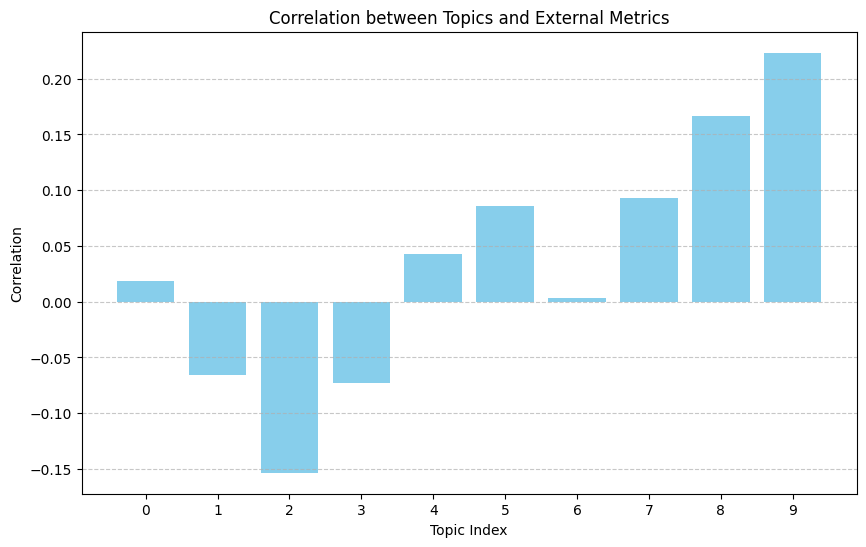

Topic 0: Correlation = 0.018889924684863914, p-value = 0.7649389441903964
Topic 1: Correlation = -0.06550060913567851, p-value = 0.2993600868457251
Topic 2: Correlation = -0.1533376659034505, p-value = 0.014631973961852205
Topic 3: Correlation = -0.07269710614750818, p-value = 0.24927289763257418
Topic 4: Correlation = 0.0429566735600838, p-value = 0.4963789401880724
Topic 5: Correlation = 0.08602857703164775, p-value = 0.1725290477071001
Topic 6: Correlation = 0.002974487875764225, p-value = 0.9624511082551659
Topic 7: Correlation = 0.09260705638319158, p-value = 0.14186823030354034
Topic 8: Correlation = 0.16657020950024215, p-value = 0.007932855894719443
Topic 9: Correlation = 0.22329296708326368, p-value = 0.0003443800973772599


In [8]:
from scipy.stats import spearmanr  # Import spearmanr instead of pearsonr
import matplotlib.pyplot as plt

def calculate_correlation(feature_vectors, external_metrics):
    if feature_vectors.shape[0] != len(external_metrics):
        raise ValueError("Number of samples in feature_vectors and external_metrics must match.")
    
    correlations = []
    p_values = []
    for i in range(feature_vectors.shape[1]):
        correlation, p_value = spearmanr(feature_vectors[:, i], external_metrics)  # Use spearmanr
        correlations.append(correlation)
        p_values.append(p_value)
    return correlations, p_values

# Perform correlation analysis
correlations, p_values = calculate_correlation(normalized_feature_vectors, external_metrics)

# Visualize correlations
plt.figure(figsize=(10, 6))
plt.bar(range(len(correlations)), correlations, color='skyblue')
plt.xlabel('Topic Index')
plt.ylabel('Correlation')
plt.title('Correlation between Topics and External Metrics')
plt.xticks(range(len(correlations)))
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# Print correlations and p-values
for idx, (corr, p_val) in enumerate(zip(correlations, p_values)):
    print(f"Topic {idx}: Correlation = {corr}, p-value = {p_val}")


In [9]:
final_df = pd.DataFrame({
    'Name': documents_df['institution'],
    'rank': documents_df['rank']
})
num_features = len(normalized_feature_vectors[0])  # Get the number of features
for i in range(num_features):
    final_df[f'feature_{i+1}'] = [vector[i] for vector in feature_vectors]

final_df

,Name,rank,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,feature_10
0,University of Wisconsin-Madison,102,0.000102,0.000102,0.000102,0.295336,0.591442,0.000102,0.111779,0.000102,0.000102,0.000102
1,The Pontifical Catholic University of Chile,103,0.402296,0.000011,0.001325,0.000011,0.003431,0.000011,0.000011,0.000011,0.033695,0.000011
2,The University of Sheffield,104,0.000078,0.000078,0.630327,0.000078,0.037733,0.000078,0.032144,0.000078,0.000078,0.000078
3,Uppsala University,105,0.000042,0.978853,0.018540,0.000042,0.000042,0.000042,0.000042,0.000042,0.000042,0.001326
4,University of Copenhagen,107,0.000147,0.584251,0.366915,0.000147,0.000147,0.000147,0.000147,0.000147,0.000147,0.000147
...,...,...,...,...,...,...,...,...,...,...,...,...
248,Belarusian State University,387,0.000247,0.000247,0.000247,0.000247,0.000247,0.000247,0.000247,0.000247,0.037634,0.401567
249,Institut National des Sciences AppliquÃ©es de ...,392,0.717238,0.000071,0.000071,0.019017,0.000071,0.000071,0.000071,0.000071,0.032460,0.130598
250,South China University of Technology,392,0.000449,0.000449,0.000449,0.000449,0.000449,0.000449,0.022035,0.000449,0.000449,0.574728
251,Justus-Liebig-University Giessen,396,0.000012,0.989928,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,0.002009,0.007893


In [10]:
csv_file_path = '/Users/nachiketh/Library/CloudStorage/OneDrive-TrinityCollegeDublin/Text_analytics/project/final_file_bow.csv'

# Dump the DataFrame to a CSV file
final_df.to_csv(csv_file_path, index=False)

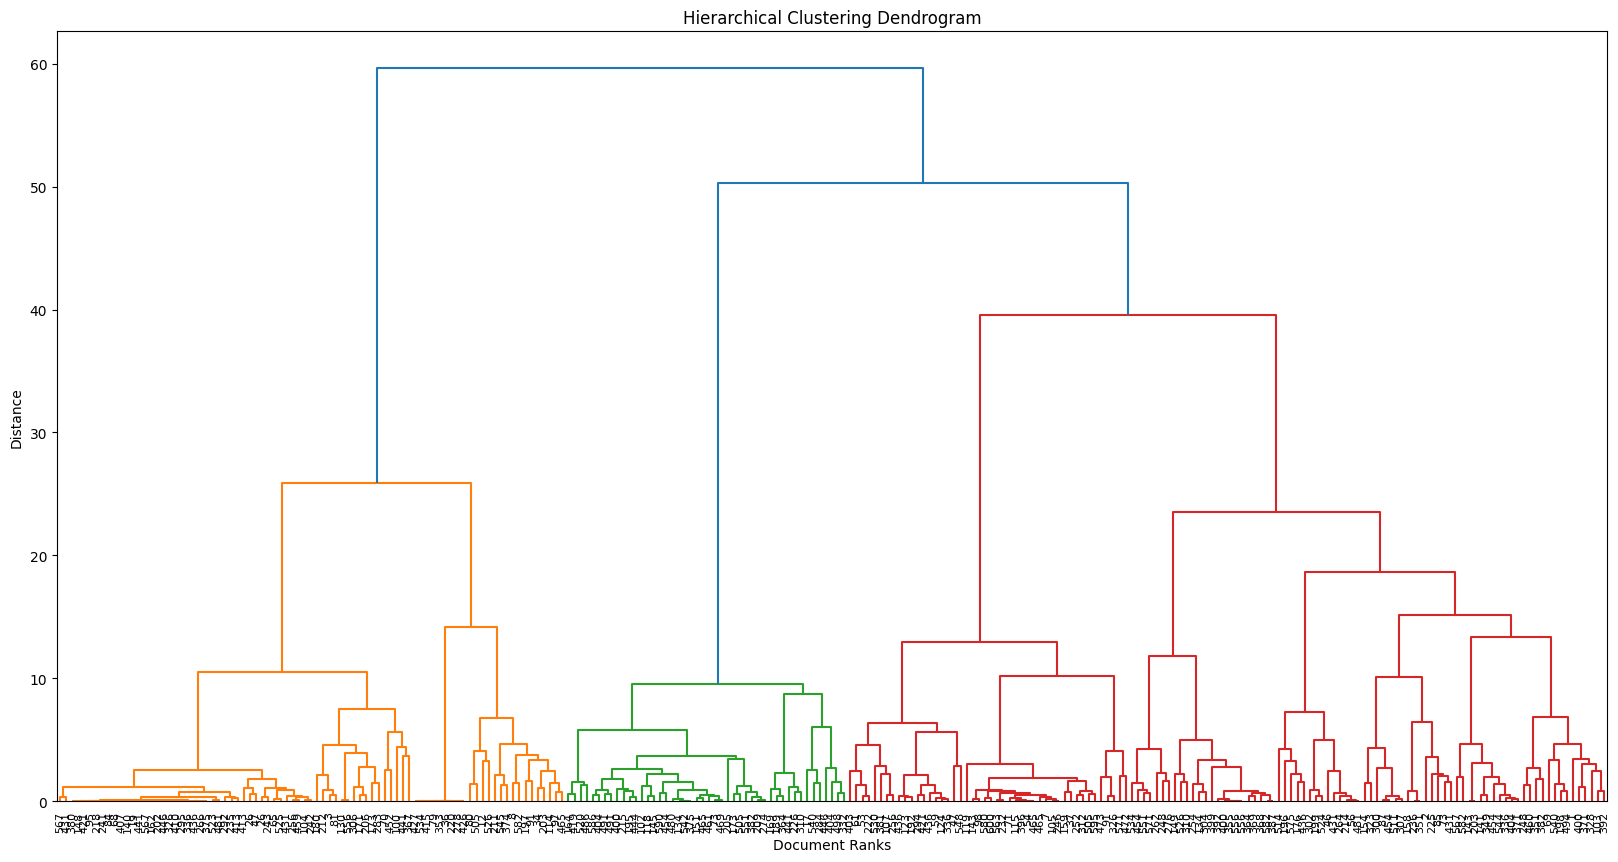

In [11]:
from sklearn.metrics.pairwise import cosine_similarity
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
import matplotlib.pyplot as plt

# Calculate cosine similarity matrix
similarity_matrix = cosine_similarity(normalized_feature_vectors)

# Convert to distance matrix
distance_matrix = 1 - similarity_matrix

# Perform hierarchical clustering using Ward's method
Z = linkage(distance_matrix, 'ward')
ranks = final_df['rank'].tolist()

# Plot the dendrogram
plt.figure(figsize=(20, 10))  # Increase figure size
dendrogram(Z, labels=ranks, leaf_rotation=90, leaf_font_size=8)  # Add ranks as labels
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Document Ranks')
plt.ylabel('Distance')
plt.show()

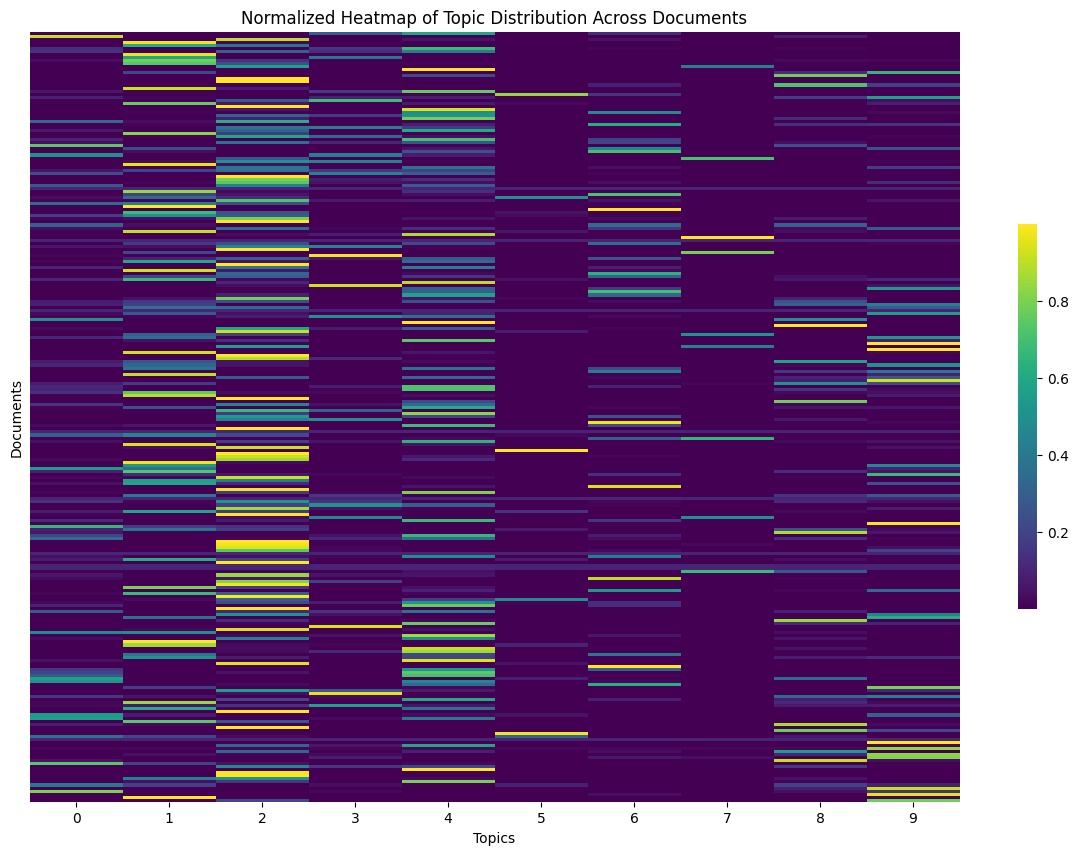

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt

# Convert the feature_vectors to a NumPy array if they aren't already
# This step is optional if your feature_vectors is already a NumPy array
import numpy as np
feature_vectors_array = np.array(normalized_feature_vectors)
plt.figure(figsize=(15, 10))
# Normalize the feature vectors to ensure the color scale is based on the relative proportion of topics in each document
normalized_feature_vectors = feature_vectors_array / feature_vectors_array.sum(axis=1, keepdims=True)
sns.heatmap(normalized_feature_vectors, cmap='viridis', yticklabels=False, xticklabels=True, cbar_kws={"shrink": .5})
plt.title('Normalized Heatmap of Topic Distribution Across Documents')
plt.xlabel('Topics')
plt.ylabel('Documents')
plt.show()


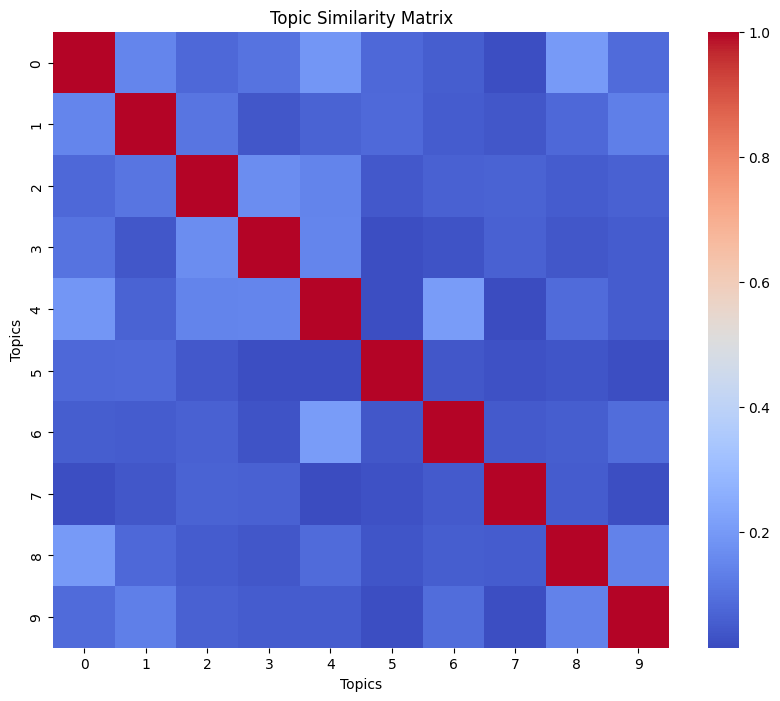

In [13]:
# Transpose the feature vectors so that rows correspond to topics and columns to documents
topic_vectors = normalized_feature_vectors.T

# Calculate the cosine similarity matrix between the topic vectors
topic_similarity_matrix = cosine_similarity(topic_vectors)

# Plot the topic similarity matrix
plt.figure(figsize=(10, 8))
sns.heatmap(topic_similarity_matrix, cmap='coolwarm', annot=False, square=True)
plt.title('Topic Similarity Matrix')
plt.xlabel('Topics')
plt.ylabel('Topics')
plt.show()


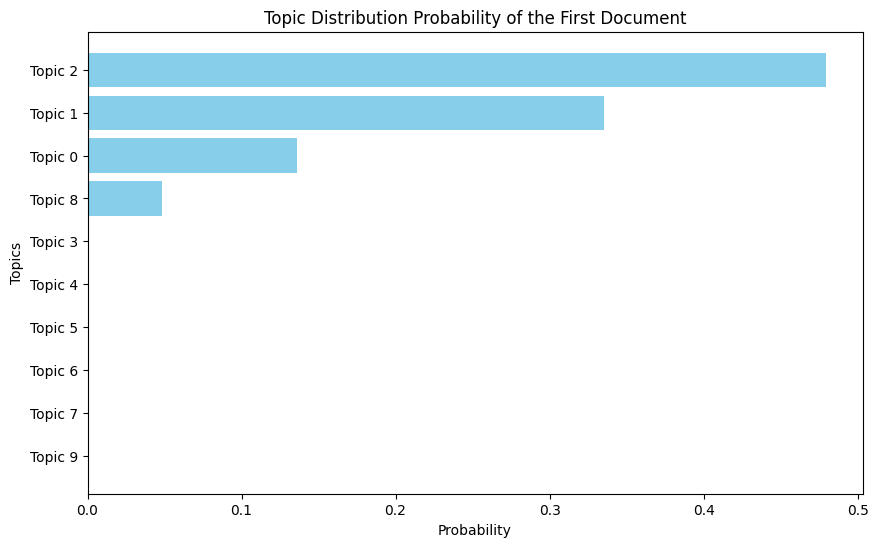

In [14]:
# Normalize the probabilities for each document
for doc_topic_distribution in topdis:
    for model_distribution in doc_topic_distribution:
        total_prob = sum(model_distribution.values())
        for topic_num in model_distribution:
            model_distribution[topic_num] /= total_prob


            
import matplotlib.pyplot as plt

# Extract the topic distribution probabilities for the first document
first_doc_topic_distribution = topdis[9][0]  

# Sort the topic probabilities in descending order
sorted_topic_probs = sorted(first_doc_topic_distribution.items(), key=lambda x: x[1], reverse=True)

# Extract topics and probabilities
topics = [f"Topic {topic_num}" for topic_num, _ in sorted_topic_probs]
probabilities = [prob for _, prob in sorted_topic_probs]

# Plot the topic distribution
plt.figure(figsize=(10, 6))
plt.barh(topics, probabilities, color='skyblue')
plt.xlabel('Probability')
plt.ylabel('Topics')
plt.title('Topic Distribution Probability of the First Document')
plt.gca().invert_yaxis()  # Invert y-axis to show the highest probability at the top
plt.show()



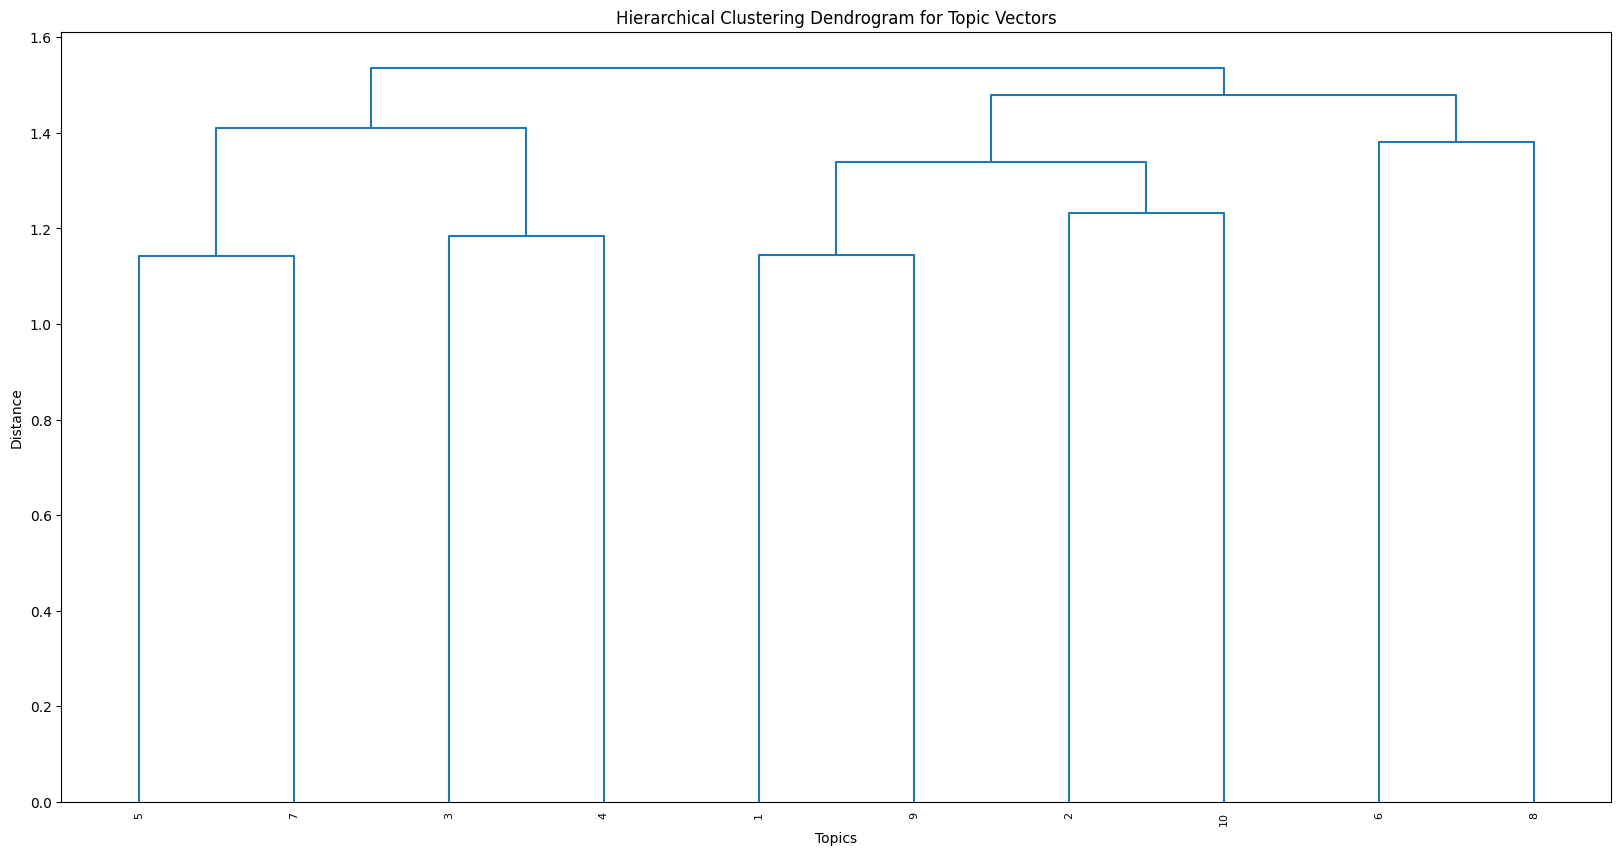

In [15]:
from sklearn.metrics.pairwise import cosine_similarity
from scipy.cluster.hierarchy import dendrogram, linkage
import matplotlib.pyplot as plt

# Calculate cosine similarity matrix for topic vectors
topic_similarity_matrix = cosine_similarity(topic_vectors)

# Convert to distance matrix
topic_distance_matrix = 1 - topic_similarity_matrix

# Perform hierarchical clustering using Ward's method
topic_Z = linkage(topic_distance_matrix, 'ward')

# Plot the dendrogram
plt.figure(figsize=(20, 10))  # Increase figure size
dendrogram(topic_Z, labels=range(1, chosen_number_of_topics + 1), leaf_rotation=90, leaf_font_size=8)  # Add topic numbers as labels
plt.title('Hierarchical Clustering Dendrogram for Topic Vectors')
plt.xlabel('Topics')
plt.ylabel('Distance')
plt.show()
